In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import numpy.ma as ma

In [27]:
x = np.concatenate((-0.5*np.logspace(1, -2,10),0.5*np.logspace(-2, 1, 10)))
y = 0.5*np.linspace(-10, 10, 20)
xx, yy = np.meshgrid(x, y)r = ma.masked_greater(xx/yy, 10)
r = ma.masked_less(r, -10)
ma.set_fill_value(r, 20)


In [30]:
z = xx*np.exp(r.filled())

In [31]:
Z = ma.masked_greater(z, 10)
Z = ma.masked_less(Z, -10)

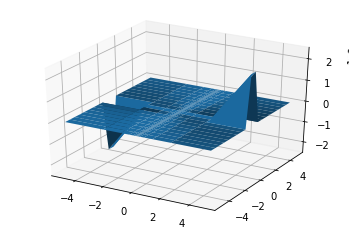

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z)
#C = plt.contourf(xx, yy, Z)
#plt.colorbar(C)
plt.show()

In [35]:
from itertools import combinations
from collections import defaultdict
import docker

In [ ]:
from itertools import combinations, izip
from collections import defaultdict
from scipy.optimize import fsolve
import docker
import re

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return list(izip(a, a))

def extract_sol(str):
    digitfinder = re.compile("-*\d+")
    find = digitfinder.findall(str)
    digits = set(map(int, find))
    if 0 in digits:
        digits.remove(0)
    return digits

def find_solutions(equations):
    cnfyvars = cnfy(equations)
    client = docker.from_env()
    maxsol = 1000
    solve_problem_cmd = "cryptominisat5 --verb 0 --maxsol {} /data/problem2.cnf".format(maxsol)
    _,out = client.containers.get("cranky_saha").exec_run(solve_problem_cmd)
    getsol = lambda sol: {sign(elt)*elt: elt>0 for elt in sol}
    all_lines = iter(out.split("\n"))
    line = all_lines.next()
    s = []
    while not (line == "s UNSATISFIABLE"):
        if line == "s SATISFIABLE":
            s.append({})
        else:
            #print("|{}|".format(line))
            s[-1].update(getsol(extract_sol(line)))
        line = all_lines.next()
    return cnfyvars, s


def cnfy(lines):
    d = defaultdict(set)
    l = defaultdict(set)
    varmap = {}
    lineids = []
    start = 1

    for linen, line in enumerate(lines):
        deps, _, _ = parse_python(line)
        depd = dict(enumerate(deps, start=start))
        lineids.append(depd.keys())
        for idx, val in depd.iteritems():
            d[val].add(idx)
            l[val].add(linen)
            varmap[idx] = val
        start += len(depd)

    repkeys = [key for key, val in l.iteritems() if len(val)>1]
    combos = []
    G=nx.Graph()
    #from itertools import combinations
    #lineid = [[1, 2], [3, 4, 5], [6]]
    #l = {"a":{0,1,2}, "b":{0,1}, "c":{2}}
    #varmap = {1:"a", 2:"b", 3:"a", 4:"b", 5:"c", 6:"a"}
    #repkeys = ["a", "b"]
    for v1,v2 in combinations(repkeys,2):
        inter = l[v1].intersection(l[v2])
        if len(inter)>1:
            intervars = [elt for line in inter for elt in lineids[line] if varmap[elt] == v1 or varmap[elt] == v2]
            #print("|>",intervars)
            combos.append(intervars)
            #G.add_edge(v1, v2)
    #combos
    #clusters = list(nx.connected_components(G))
    #indcluster = reduce(lambda a,b: a.difference(b), [set(repkeys)]+clusters)

    #for cluster in clusters:
    #    combos.append(reduce(lambda a,b: a.union(b), [d[a] for a in cluster]))
    indcluster = [key for key,var in d.iteritems() if len(var)>1]
    combos.extend([d[a] for a in indcluster])
    #clusters
    #print(combos)
    #combos
    #d
    #https://math.stackexchange.com/questions/214338/how-to-convert-to-conjunctive-normal-form
    # https://math.stackexchange.com/questions/736205/what-is-the-cnf-for-at-most-one
    # https://math.stackexchange.com/questions/2554805/writing-in-cnf-that-only-one-statement-can-be-true
    # https://fairmut3x.wordpress.com/2011/07/29/cnf-conjunctive-normal-form-dimacs-format-explained/
    def combocnf(combo):
        return [[-c1, -c2, 0] for c1, c2 in combinations(combo,2)]

    def linencf(line):
        str = [list(line)+[0]]
        str.extend(combocnf(line))
        return str

    cnf = []
    for line in lineids:
        #print(line, linencf(line))
        cnf.extend(linencf(line))
    for combo in combos:
        #print(combo, "|", combocnf(combo))
        cnf.extend(combocnf(combo))

    def cnflist2line(lst):
        return " ".join(map(str,lst))

    def cnflist2str(cnf):
        return "\n".join(map(cnflist2line, cnf))

    with open("../sat/problem2.cnf", "w") as text_file:
        cnfstr = "p cnf {} {}\n".format(start-1, len(cnf))
        cnfstr += cnflist2str(cnf)
        text_file.write(cnfstr)
    return d, l, varmap, lineids, G
